In [5]:
'''
# 安裝所需的 Python 套件
!pip install stable-baselines3
!pip install gymnasium
!pip install gymnasium[classic_control]
!pip install backtrader
!pip install yfinance
!pip install matplotlib
'''
!pip install torch
import torch
print(torch.cuda.is_available())

ModuleNotFoundError: No module named 'torch'

In [29]:
# 匯入程式所需的 Python 庫
import pandas as pd
import numpy as np
import yfinance as yf
import backtrader as bt
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from gymnasium import spaces
import gymnasium as gym
import torch
import torch.nn as nn

import warnings

# 禁用所有警告
warnings.filterwarnings('ignore')

In [30]:
# 從 Yahoo Finance 下載 Apple 的歷史數據
data = yf.download('AAPL', start='2015-01-01', end='2021-01-01')
data.reset_index(inplace=True)
data['Date'] = pd.to_datetime(data['Date'])
data = data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
data.set_index('Date', inplace=True)

# 確保數據類型正確
data = data.astype('float32')
data.head()



[*********************100%***********************]  1 of 1 completed


Price,Open,High,Low,Close,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2015-01-02,27.847500,27.860001,26.837500,27.332500,212818400.0
2015-01-05,27.072500,27.162500,26.352501,26.562500,257142000.0
2015-01-06,26.635000,26.857500,26.157499,26.565001,263188400.0
2015-01-07,26.799999,27.049999,26.674999,26.937500,160423600.0
2015-01-08,27.307501,28.037500,27.174999,27.972500,237458000.0


In [31]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd

# 定義交易環境
class TradingEnv(gym.Env):
    def __init__(self, data, window_size=15, cash=10000, commission=0.001):
        """
        初始化交易環境。
        
        :param data: 股票數據（包含 'Open', 'High', 'Low', 'Close', 'Volume' 欄位的 Pandas DataFrame）
        :param window_size: 用來決定觀察空間大小（即時間窗口的大小）
        :param cash: 初始現金
        :param commission: 交易手續費比例
        """
        super(TradingEnv, self).__init__()

        # 股票資料設定
        self.data = data.reset_index()  # 重置索引，讓數據從 0 開始索引
        self.cash = cash  # 當前現金
        self.initial_cash = cash  # 初始現金
        self.commission = commission  # 交易手續費比例
        self.window_size = window_size  # 設定的時間窗口大小
        self.current_step = self.window_size  # 當前的時間步，從第 window_size 開始
        self.position = 0  # 當前持有的股票數量
        self.net_worth = self.cash  # 當前的淨值（現金 + 持有的股票價值）
        self.prev_net_worth = self.cash  # 上一個時間步的淨值，用來計算獎勳

        # 觀察空間設定：這裡是 (window_size, 5)，對應每個時間步的 [Open, High, Low, Close, Volume]
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(self.window_size, 5), dtype=np.float32
        )

        # 動作空間設定：共三個動作：0 - 保持、1 - 買入、2 - 賣出
        self.action_space = spaces.Discrete(3)

        # 記錄交易歷史
        self.trades = []

    def _get_obs(self):
        """
        根據當前時間步返回觀察結果，觀察為股票的 OHLCV 資料（Open, High, Low, Close, Volume）。
        窗口大小決定了觀察的時間範圍。
        
        :return: 觀察結果，形狀為 (window_size, 5)
        """
        # 返回當前時間步之前的 window_size 天的股票資料
        obs = self.data.loc[
            self.current_step - self.window_size:self.current_step - 1,
            ['Open', 'High', 'Low', 'Close', 'Volume']
        ].values
        return obs

    def reset(self, *, seed=None, options=None):
        """
        重置環境，初始化當前狀態並返回第一個觀察。
        
        :param seed: 隨機種子
        :param options: 其他選項（可擴展性）
        :return: 初始觀察
        """
        super().reset(seed=seed)

        # 重置環境狀態
        self.current_step = self.window_size  # 當前時間步重置
        self.position = 0  # 持股數量重置
        self.cash = self.initial_cash  # 現金重置為初始值
        self.net_worth = self.cash  # 淨值重置
        self.prev_net_worth = self.cash  # 前一步的淨值重置
        self.trades = []  # 清空交易記錄

        # 返回當前觀察
        obs = self._get_obs()
        return obs, {}

    def step(self, action):
        """
        執行指定的動作，並返回新的觀察、獎勳、是否結束和是否截斷的信息。
        
        :param action: 動作，0 - 保持、1 - 買入、2 - 賣出
        :return: (新的觀察, 獎勳, 是否結束, 是否截斷, 其他信息)
        """
        # 獲取當前股票價格
        current_price = self.data.loc[self.current_step, 'Close']
        date = self.data.loc[self.current_step, 'Date']
        
        # 記錄當前的動作
        self.trades.append({'Date': date, 'Action': action})

        # 手續費初始化
        commission = 0

        # 根據動作執行買賣操作
        if action == 1:  # 買入
            max_shares = int(self.cash / (current_price * (1 + self.commission)))  # 計算最多可以購買的股數
            if max_shares > 0:
                # 計算購買成本
                cost = max_shares * current_price * (1 + self.commission)
                self.cash -= cost  # 扣除現金
                self.position += max_shares  # 更新持股數量
                commission = cost * self.commission  # 計算手續費

        elif action == 2:  # 賣出
            if self.position > 0:  # 有持股才可賣出
                # 計算賣出收入
                revenue = self.position * current_price * (1 - self.commission)
                self.cash += revenue  # 收回現金
                commission = self.position * current_price * self.commission  # 計算手續費
                self.position = 0  # 更新持股數量為 0

        # 更新時間步
        self.current_step += 1

        # 計算當前的淨值
        self.net_worth = self.cash + self.position * current_price

        # 計算獎勳，為當前淨值和前一步淨值之差，再扣除手續費
        reward = self.net_worth - self.prev_net_worth - commission
        self.prev_net_worth = self.net_worth  # 更新前一步的淨值

        # 檢查是否結束（達到最後一天）
        terminated = self.current_step >= len(self.data)
        truncated = False  # 目前沒有截斷邏輯

        # 返回新的觀察
        obs = self._get_obs()
        return obs, float(reward), terminated, truncated, {}

    def render(self):
        """
        渲染當前狀態，這裡可以自定義顯示的方式（例如輸出畫面或圖表）。
        目前此方法為空，您可以根據需要擴展。
        """
        pass


In [32]:
# 定義一個自訂的特徵提取器類別，繼承自 BaseFeaturesExtractor
class CustomFeatureExtractor(BaseFeaturesExtractor):
    
    # 初始化方法，接收觀察空間和LSTM單元數作為參數
    def __init__(self, observation_space, lstm_units=64):
        # 初始化父類別 BaseFeaturesExtractor，並指定特徵維度為 64
        super(CustomFeatureExtractor, self).__init__(observation_space, features_dim=64)
        
        # 獲取觀察空間的特徵數量，這是環境中每個時間步的觀察數據的維度
        n_input_features = observation_space.shape[1]  # 假設觀察空間為2D (batch_size, n_features)

        # 定義 LSTM 層。LSTM 的輸入大小是觀察空間的特徵數，隱藏層大小是給定的 lstm_units。
        # batch_first=True 表示輸入數據的形狀為 (batch_size, seq_len, features)
        self.lstm = nn.LSTM(input_size=n_input_features, hidden_size=lstm_units, batch_first=True)
        
        # 定義全連接層（線性層），將 LSTM 的輸出壓縮為 64 維
        self.fc = nn.Linear(lstm_units, 64)

    # 前向傳播方法，用於計算特徵提取過程
    def forward(self, observations):
        # 將觀察數據通過 LSTM 層
        # lstm_out 是 LSTM 的輸出，_ 是 LSTM 的隱藏狀態（我們不會在這裡使用它）
        lstm_out, _ = self.lstm(observations)
        
        # 使用 LSTM 輸出的最後一個時間步的結果，通過全連接層進行壓縮
        # lstm_out[:, -1, :] 取最後一個時間步的輸出（對應於時間序列的最後一個觀察）
        return self.fc(lstm_out[:, -1, :])  # 返回的結果是 64 維的特徵向量


In [33]:
# 創建交易環境
env = DummyVecEnv([lambda: TradingEnv(data)])

# 檢查環境是否符合穩定基線要求
check_env(TradingEnv(data))



In [34]:
# 設定政策模型的參數，包含特徵提取器
policy_kwargs = dict(
    # 定義自訂的特徵提取器類別
    features_extractor_class=CustomFeatureExtractor,
    # 傳遞給特徵提取器的額外參數
    features_extractor_kwargs=dict(lstm_units=64)
)

# 初始化PPO模型
model = PPO(
    # 定義政策模型類型，這裡使用 "MlpPolicy"，即多層感知器（MLP）政策模型
    # 這表示將使用全連接的神經網絡來學習策略
    "MlpPolicy",
    
    # 提供環境實例，即模型將在哪個環境上進行訓練
    env,
    
    # 傳遞設定給政策模型的額外參數（例如，特徵提取器的類型和參數）
    policy_kwargs=policy_kwargs,
    
    # 設定輸出詳細信息的級別，verbose=1 會顯示訓練過程中的基本信息
    verbose=1,
    
    # 設定學習率，這是模型參數更新的步伐大小。學習率較小的值可以讓模型更穩定地收斂
    learning_rate=0.0003,
    
    # 設定每一個更新的步數，即每次訓練中使用的樣本數量。2048 是一個常見的設定，這會影響每次訓練時使用的經驗回放大小
    n_steps=2048
)

# 訓練模型
# model.learn 用於開始訓練模型。total_timesteps 是訓練的總步數，也就是訓練過程中的總時間步數。
# 在這裡，我們將訓練模型 100,000 步
model.learn(total_timesteps=100000)


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 499  |
|    iterations      | 1    |
|    time_elapsed    | 4    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 445         |
|    iterations           | 2           |
|    time_elapsed         | 9           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.002483116 |
|    clip_fraction        | 0.0144      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.1        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 5.8e+04     |
|    n_updates            | 10          |
|    policy_gradient_loss | 0.00021     |
|    value_loss           | 1.01e+05    |
-----------------------------------------
-----------------

ConversionError: Failed to convert value(s) to axis units: array([Ticker
           2015-01-26 00:00:00
       Name: 15, dtype: object, Ticker
                                    2015-01-27 00:00:00
                                Name: 16, dtype: object,
       Ticker
           2015-01-28 00:00:00
       Name: 17, dtype: object, ..., Ticker
                                         2020-12-29 00:00:00
                                     Name: 1508, dtype: object,
       Ticker
           2020-12-30 00:00:00
       Name: 1509, dtype: object, Ticker
                                      2020-12-31 00:00:00
                                  Name: 1510, dtype: object], dtype=object)

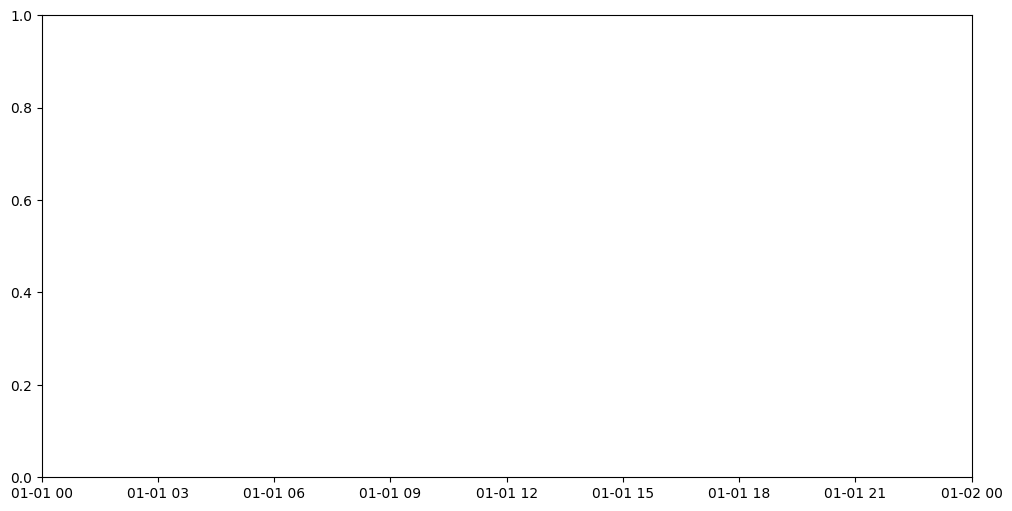

In [35]:
# 初始化交易環境，將數據傳入環境中
env = TradingEnv(data)  # 在這裡 'data' 是你的股市數據
obs, _ = env.reset()  # 重設環境並獲取初始的觀察數據，這裡的 _ 是額外的返回值（在此不需要）

# 開始交易模擬
for _ in range(len(data) - env.window_size):  # 從 window_size 開始，直到數據結束
    # 使用已訓練的模型來預測動作（行為）。模型將根據當前的觀察數據返回一個動作
    action, _ = model.predict(obs)
    
    # 根據預測的動作更新環境狀態，並返回新的觀察數據、回報、是否終止或被截斷等
    obs, reward, terminated, truncated, _ = env.step(action)
    
    # 如果交易已結束（終止或被截斷），則跳出循環
    if terminated or truncated:
        break

# 可視化交易結果，使用 Matplotlib 畫出資產淨值隨時間的變化
import matplotlib.pyplot as plt  # 引入繪圖庫

# 提取環境中的交易紀錄，並將其轉換為 DataFrame
trades = pd.DataFrame(env.trades)
trades['Net Worth'] = env.net_worth  # 計算每次交易的淨資產，將其新增到 DataFrame 中

# 設定畫圖的大小，這裡指定為 12x6 英寸
plt.figure(figsize=(12, 6))

# 畫出資產淨值隨時間的變化，x 軸為交易日期，y 軸為資產淨值
plt.plot(trades['Date'], trades['Net Worth'], label='Net Worth')

# 設置圖標題
plt.title('Trading Simulation Result')

# 設置 x 軸和 y 軸的標籤
plt.xlabel('Date')
plt.ylabel('Net Worth')

# 顯示圖例，標明這條曲線代表資產淨值
plt.legend()

# 顯示畫出的圖
plt.show()


In [36]:
# 定義策略
class ReinforcementLearningStrategy(bt.Strategy):
    def __init__(self):
        # 初始化：設定資料中的收盤價為 dataclose
        self.dataclose = self.datas[0].close  # 使用第一個資料源的收盤價作為決策依據
        self.position = 0  # 初始化持倉狀態，0 代表無持倉

    def next(self):
        # 每一個新的時間步，這個方法會被調用
        if not self.position:  # 如果當前沒有持倉
            # 簡單的買入條件：如果今天的收盤價高於昨天的收盤價，則進行買入
            if self.dataclose[0] > self.dataclose[-1]:
                self.buy()  # 執行買入操作
        else:
            # 如果已經有持倉，則設定簡單的賣出條件：當前收盤價低於昨天收盤價，則進行賣出
            if self.dataclose[0] < self.dataclose[-1]:
                self.sell()  # 執行賣出操作
                
                
# 創建回測環境
cerebro = bt.Cerebro()  # 初始化 Backtrader 的回測引擎

# 設置數據來源，這裡使用 PandasData 格式的數據源
data_feed = bt.feeds.PandasData(dataname=data)  # data 需要是一個 Pandas DataFrame
cerebro.adddata(data_feed)  # 將數據源添加到回測引擎中

# 添加策略到回測引擎中
cerebro.addstrategy(ReinforcementLearningStrategy)

# 設定初始現金為 10000
cerebro.broker.set_cash(10000)

# 執行回測
print("Starting Portfolio Value: %.2f" % cerebro.broker.getvalue())  # 顯示回測開始時的資金
cerebro.run()  # 開始執行回測

# 顯示回測結果的最終資產價值
print("Ending Portfolio Value: %.2f" % cerebro.broker.getvalue())

# 顯示回測結果的圖表
cerebro.plot()


Starting Portfolio Value: 10000.00


AttributeError: 'tuple' object has no attribute 'lower'